# Vibration kit data analysis notebook
This is a test notebook and you should not take any of this too seriously, as it's mostly to test Jupyterhub functionality.

This is made by Davide Crivelli (davide.crivelli@diamond.ac.uk) and the main function is for beamlines to look at vibration data during an experiment, to see if something weird happened. It is intended to provide a nicer interface and nicer stats than those you can get from the synoptic and CS Studio.

It would be nice if this works in Jupyterhub so that people don't have to spin their own instance of Jupyter on any machine they use.

In [2]:
from datetime import datetime, timedelta, timezone
from string import ascii_uppercase

from aa.js import JsonFetcher

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

from vc_curves import vc_get_level, vc_get_threshold
from vib_data import fetch_pv_to_dataframe

ModuleNotFoundError: No module named 'dlsVibrationTools'

## Todo
 
 * peak velocity / time: add VC level references
 * handle multiple PV channels
 * add PSS PV to avoid triggering alarms in that time
 * collapse alarms together to calculate duration
 * let user specify an alarm minimum duration to include in the report
 * move support functions to external library
 * package the "get data" in external functions
 
Nice to have:
 * spectrograms and PSDs from waveforms in EPICS

## User parameters

In [ ]:
# PV names and date range
pv_name = 'BL20I-DI-ACCEL-01:DATA:CH01:VC_PEAK'
#end_date = datetime.now(timezone.utc).astimezone()
#start_date = end_date - timedelta(hours=24*7)

start_date = datetime(2022, 5, 3).astimezone()
end_date = datetime(2022, 5, 5).astimezone()

# Threshold for "alarms" report (will trigger if above the velocity required to meet this level's spec)
vc_threshold = 'G'

print(repr(start_date))

## Other parameters

In [ ]:
# plots and styling
#sns.set_context("talk")
sns.set_style("whitegrid")
matplotlib.use('nbagg')

# how many VC reference lines do we want to see in the VC plots
vc_gridlines = [3,10]

#plt.rcParams['figure.figsize']=(14,8)
#sns.set(rc={'figure.figsize':(14,8)})

## Get and process the data

In [ ]:
df = fetch_pv_to_dataframe(pv_name = pv_name, 
    start_date = start_date,
    end_date = end_date)

df.info()
df.head()


# Plots

## Peak velocity over time
This graph shows the peak velocity over time over 1/3 octave band. This is closely related to the "VC" curve concept (https://confluence.diamond.ac.uk/display/VIB/VC+curves) and represents how "good" the floor is at any given time.

<IPython.core.display.Javascript object>


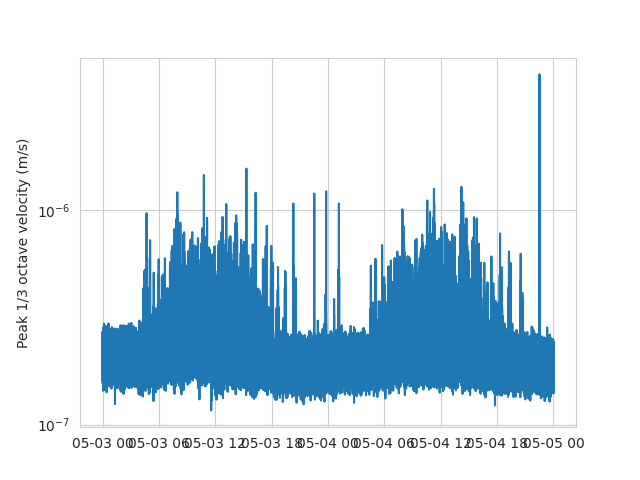

<IPython.core.display.Javascript object>


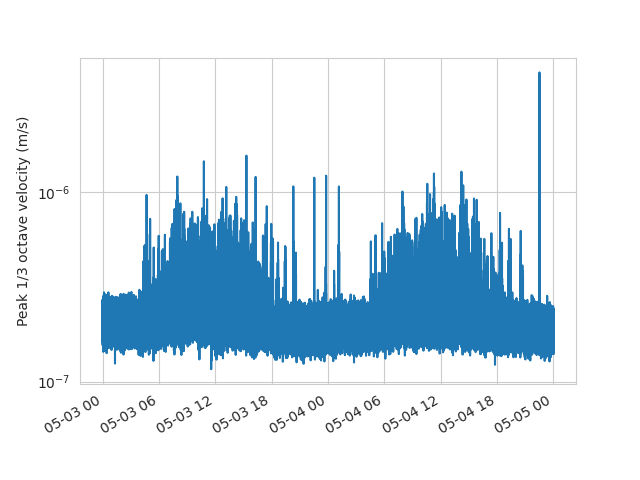

In [6]:
#ax = sns.lineplot(data=df, x='Time', y='VC_Peak')
fg = plt.figure()
ax = fg.add_subplot(1, 1, 1)

plt.plot(df['Time'], df['VC_Peak'])
ax.set_ylabel('Peak 1/3 octave velocity (m/s)')

ax.set_yscale('log')


#for (limit, label) in zip(VC_UPPER_LIMIT[vc_gridlines[0]:vc_gridlines[1]],
#                            VC_LABELS[vc_gridlines[0]:vc_gridlines[1]]):
#    plt.axhline(limit,
#        linestyle = 'dotted',
#        color = [0.5, 0.5, 0.5]
#        )
#    plt.text(x=end_date, y=limit, s='VC-'+label)

fg.figure.autofmt_xdate()

plt.show()

## Time spent at each VC level
This shows a hystogram, useful to understand how long is spent at each VC level

In [ ]:
fig = sns.histplot(data=df, x='VC_Level', weights='dT_Seconds')

fig.bar_label(fig.containers[0])
fig.set_ylabel('Time at level (s)')
fig.invert_xaxis()
plt.show()

# Summary of alarms

Todo - Ideally this should show a list of times where the alarm starts and ends (rather than all of the alarms) and also let the user export this as a csv.

In [ ]:
alarm_list = df.loc[df['VC_Alarm']==True].copy()

alarm_list['Time_To_Next'] = alarm_list['Time'].shift(-1) - alarm_list['Time']

alarm_list.info()
#alarm_list.head()




alarms = []

#build list of dicts
alarm = {}
for row in alarm_list.to_dict(orient="records"):
    
    
    # if the next row is a continuation of the current row
    if(row['Time_To_Next'] - row['dT'] == timedelta(0)):
    
        alarm['Time'] = row['Time']
        alarm['VC_Peak'] = row['VC_Peak'] # TODO: store mean/max here
        alarm['Duration'] = row['dT'] #TODO: increment logic here

    #alarm_list[alarm_list['Time_To_Next'] - alarm_list['dT'] == timedelta(0)]
    
    alarms.append(alarm)

    
    
alarm_df = pd.DataFrame(alarms)
alarm_df.head()

# calculate VC max level



# go through all alarms and build a new dataframe containing 
# event ID, if time + dT = time of next, then same event ID, otherwise increment event ID.



# This way we can use standard Pandas groupby event ID and calculate
# peak of peak, time of peak, duration (sum of dT), median of peak over duration... all of the stats



I would also like to display a probability distribution of the threshold crossings duration!